# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words. **Listo**


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos. **Listo**


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas. **Listo**


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo. **Listo**


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador. **Listo**

##1. Procesamiento de datos

####Cargamos las librerias

In [0]:
import pandas as pd
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.neural_network import MLPClassifier

####Creamos el conjunto de datos con base al ejemplo del profesor que se presenta en el siguiente link




>###### https://jdvelasq.github.io/courses/notebooks/sklearn/bayes/02-filtrado-de-mensajes-sms.html?highlight=stemmer




In [132]:
#Leemos el conjunto de datos
conjuntoDatos = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

#mostramos la cabecera para comprobar que los datos se cargaron correctamente
conjuntoDatos.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [133]:
#Mostramos la descripción del conjunto de datos
conjuntoDatos.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


####Mostramos cuantos mensajes hay por cada clasificación (ham o spam) con la intención de observar como se comportan los datos.

In [134]:
conjuntoDatos.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

Posteriormente graficamos el conteo de los datos

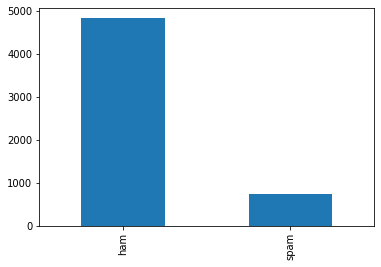

In [135]:
conjuntoDatos.type.value_counts().plot.bar();

Del grafico podemos observar que la mayor parte de los mensajes pertenecen a la categoría ham

####Usamos la función Stemmer para transformar las palabras a su forma mas general

In [136]:
#Creamos el stemmer
stemmer = PorterStemmer()

#Aplicamos el stemmer al conjunto de datos y guardamos sus resultados en una nueva columna
conjuntoDatos['stemmed'] = conjuntoDatos.text.apply(lambda x: ' '.join([stemmer.stem(palabra) for palabra in x.split() ]))

#Para comprobar el resultado mostramos el conjunto de datos
conjuntoDatos.head(5)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."


####Creamos la matriz de terminos del documento

In [137]:
#Creamos la matriz de terminos del documento
count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5)               # ignora palabras con baja freq

#Aplicamos la función al conjunto de datos
dtm = count_vect.fit_transform(conjuntoDatos.stemmed)

#Las filas contienen los mensajes
#y las clomunas los términos
dtm.shape

(5574, 1540)

In [138]:
#Palabras aprendidas de los mensajes de texto
vocabulario = count_vect.get_feature_names()
len(vocabulario)

1540

In [139]:
# Mostramos algunas de las palabras aprendidas de los mensajes de texto
vocabulario[995:1000]

['park', 'parti', 'partner', 'pass', 'passion']

####Recuperamos los mensajes transformados y mostramos la comparación con los originales

In [140]:
# Recupera los mensajes de la dtm
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

#Mostramos los cuatro mensajes de la dtm junto al original para notar la comparación
for i, x in enumerate(dtm2words(dtm, vocabulario, [0, 1, 2, 3])):
    print('Org: ', conjuntoDatos.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say



##2. Modelo de regresión logistica

Dividimos los datos en entrenamiento y prueba

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dtm, conjuntoDatos.type, test_size=0.30)

Creamos la regresión logistica

In [0]:
regresionLogistica = LogisticRegression(
    penalty='l2',            # ‘l1’, ‘l2’, ‘elasticnet’, ‘none’
    tol=0.0001,              # stop criteria
    C=1.0,                   # factor inverso para regularizacion (SVM)
    fit_intercept=True,      #
    class_weight=None,       # None, dict or ‘balanced’
    random_state=None,       #
    solver='lbfgs',          # 'newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
    max_iter=100,            #
    multi_class='auto',      # ‘ovr’, ‘multinomial’, ‘auto’
    verbose=0,               #
    warm_start=False,        # ?re-usa la solución previa
    l1_ratio=None            # Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1
)

#Entrenamos la regresión logistica 
regresionLogistica.fit(X_train,y_train);

####**Creamos la matriz de confusión para la regresión logistica:**

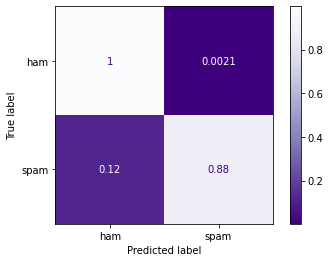

In [143]:
plot_confusion_matrix(regresionLogistica,X_test,y_test,normalize='true',cmap='Purples_r',);

En la matriz de confusión del modelo de regresión logistica podemos notar que se obtienen excelentes resultados a la hora de detectar correo ham, pero se tienen algunos errores para detectar spam, este modelo sería idoneo para filtrar el correo de una bandeja de entrada, pero no tanto para filtrar una bandeja de spam.

####**Establecemos la robustez de la regresión logistica usando validación cruzada:**

In [144]:
resultadosValidacion = cross_val_score(regresionLogistica, X_test, y_test, cv=10)
print("Resultado: %0.2f (+/- %0.2f)" % (resultadosValidacion.mean(), resultadosValidacion.std() * 2))

Resultado: 0.97 (+/- 0.03)


Con el resultado de la validación cruzada podemos concluir que el modelo de regresión logistica es robusto y se comporta adecuadamente, ya que la clasificación que realiza respecto a correos ham o spamm es bastante acertada.

##3.Redes neuronales

Creamos la red neuronal y buscamos el numero optimo de neuronas

In [0]:
#Creamos el conjunto de datos donde guardaremos la información de las neuronas y la media
neuronas=pd.DataFrame(columns=['Neuronas','Media'])

#Iteramos sobre el numero de neuronas
for numeroNeuronas in range(1,10):
  #Creamos la red neuronal
  redNeuronal= MLPClassifier(hidden_layer_sizes=(numeroNeuronas, ),
                      activation = 'relu',
                      learning_rate = 'adaptive',
                      momentum = 0.9,
                      solver= 'sgd',
                      learning_rate_init = 0.01,
                      max_iter = 1000,
                      random_state=0)
  
  #Entrenamos la red neuronal
  redNeuronal.fit(X_train,y_train)

  #Realizamos validación cruzada
  resultadosValidacion = cross_val_score(redNeuronal, X_test, y_test, cv=10,scoring='accuracy')
  #Guardamos el resultado de la media dado por la validación cruzada
  media=resultadosValidacion.mean()

  #Guardamos el numero de neuronas y la media de la validación cruzada
  neuronas = neuronas.append({
                    "Neuronas": numeroNeuronas,
                    "Media": media
                },ignore_index=True)

Buscamos el numero optimo de neuronas

In [146]:
#Encontramos el numero optimo de neuronas con base en la media maximo de todos los modelos
neuronasOptimas = neuronas[neuronas['Media']==max(neuronas['Media'])]
#Mostramos el numero de neuronas optimas
neuronasOptimas

,Neuronas,Media
0,1.0,0.983251


Creamos el modelo de redes neuronales con el numero optimo de neuronas

In [0]:
#Creamos el modelo de redes neuronales
redNeuronalOptimizada= MLPClassifier(hidden_layer_sizes=(int(neuronasOptimas['Neuronas']), ),
                                     activation = 'relu',
                                     learning_rate = 'adaptive',
                                     momentum = 0.9,
                                     solver= 'sgd',
                                     learning_rate_init = 0.01,
                                     max_iter = 1000,
                                     random_state=0)

#Entrenamos el modelo
redNeuronalOptimizada.fit(X_train,y_train);

####**Creamos la matriz de confusión para la red neuronal:**

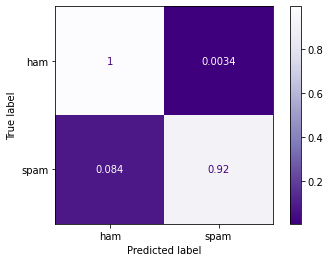

In [148]:
#Presentamos la matriz de confusión
plot_confusion_matrix(redNeuronalOptimizada,X_test,y_test,normalize='true',cmap='Purples_r');

En la matriz de confusión del modelo de redes neuronales podemos notar que al igual que con el caso de la regresión logistica se obtienen excelentes resultados a la hora de detectar correo ham, respecto al correo spam continuamos teniendo errores pero estos son menores que los del modelo de regresión logistica, por lo tanto concluimos que la red neuronal es mas optima a la hora de filtrar correo ham y spam.

####**Establecemos la robustez de la red neuronal usando validación cruzada:**

In [149]:
resultadosValidacion = cross_val_score(redNeuronalOptimizada, X_test, y_test, cv=10,scoring='accuracy')
print("Resultado: %0.2f (+/- %0.2f)" % (resultadosValidacion.mean(), resultadosValidacion.std() * 2))

Resultado: 0.98 (+/- 0.02)


Con el resultado de la validación cruzada podemos concluir que el modelo de redes neuronales es robusto y se comporta adecuadamente, ya que la clasificación que realiza respecto a correos ham y spam es bastante acertada, adicionalmente notamos que estos resultados son mejores que los de la regresión logistica, Además junto con la conclusión de la matriz de confusión podemos afirmar que este es el mejor de los dos modelos para clasificación de correos ham y spmm.